In [1]:
import pandas as pd
import numpy as np
import re
import joblib
import json
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
sns.set_style("whitegrid")

print("Библиотеки успешно импортированы.")

Библиотеки успешно импортированы.


In [2]:
DATA_PATH = '../data/ads_export.csv'

try:
    df = pd.read_csv(DATA_PATH)
    print(f"✅ Данные успешно загружены из '{DATA_PATH}'.")
    print(f"   - Всего записей: {len(df)}")
except FileNotFoundError:
    print(f"❌ Ошибка: Файл '{DATA_PATH}' не найден. Сделайте экспорт данных из Docker.")
    df = pd.DataFrame()

if not df.empty:
    display(df.head())

✅ Данные успешно загружены из '../data/ads_export.csv'.
   - Всего записей: 4959


,avito_id,url,title,price,description,location,published_at,condition,seller_name,seller_rating,seller_reviews_count,model,memory
0,7695007829,https://www.avito.ru/moskva/telefony/iphone_11...,"iPhone 11, 64 ГБ",10000,"Продаю айфон 11, айклауд взломали.",Москва,2025-10-08 16:01:32.99059+00,Б/у,Анна,4.8,16.0,NaN,NaN
1,7743661402,https://www.avito.ru/moskva/telefony/iphone_11...,"iPhone 11, 64 ГБ",10998,"Продаю iphone 11 на 64гб в хорошем состоянии, ...",Москва,2025-10-08 14:01:32.998022+00,Б/у,NaN,NaN,NaN,NaN,NaN
2,7684049927,https://www.avito.ru/moskva/telefony/iphone_11...,"iPhone 11, 64 ГБ",9000,Телефон в рабочем состоянии. Трещина не мешают...,Москва,2025-10-08 13:01:33.003023+00,Б/у,NaN,NaN,NaN,NaN,NaN
3,7789880055,https://www.avito.ru/moskva/telefony/iphone_11...,"iPhone 11, 64 ГБ",9500,"Телефон в хорошем состоянии, работает отлично....",Москва,2025-10-08 13:01:33.00728+00,Б/у,NaN,NaN,NaN,NaN,NaN
4,7674616969,https://www.avito.ru/moskva/telefony/iphone_11...,"iPhone 11, 64 ГБ",12990,Телефон в отличном состоянии!\n\nРодной Акб 89...,Москва,2025-10-08 13:01:33.011891+00,Б/у,AppleRoom,5.0,2.0,NaN,NaN


In [3]:
print("Начинаем очистку данных...")

original_count = len(df)
perfect_title_pattern = r'^iPhone[\w\s]+,\s\d+\s(?:ГБ|ТБ)$'
df = df[df['title'].str.match(perfect_title_pattern, na=False)].copy()
print(f"   - Отфильтровано по идеальному формату title: осталось {len(df)} из {original_count} записей.")

if not df.empty:
    split_data = df['title'].str.split(', ', n=1, expand=True)
    df['model'] = split_data[0].str.strip()
    df['memory'] = split_data[1].str.strip()

original_count = len(df)
if not df.empty:
    df['lower_bound'] = df.groupby(['model', 'memory'])['price'].transform(lambda x: x.quantile(0.01))
    df['upper_bound'] = df.groupby(['model', 'memory'])['price'].transform(lambda x: x.quantile(0.99))
    df = df[(df['price'] >= df['lower_bound']) & (df['price'] <= df['upper_bound'])].copy()
print(f"   - Удалены выбросы по цене: осталось {len(df)} из {original_count} записей.")

print("✅ Очистка данных завершена.")
display(df[['title', 'model', 'memory', 'price']].head())

Начинаем очистку данных...
   - Отфильтровано по идеальному формату title: осталось 4643 из 4959 записей.
   - Удалены выбросы по цене: осталось 4465 из 4643 записей.
✅ Очистка данных завершена.


,title,model,memory,price
0,"iPhone 11, 64 ГБ",iPhone 11,64 ГБ,10000
1,"iPhone 11, 64 ГБ",iPhone 11,64 ГБ,10998
2,"iPhone 11, 64 ГБ",iPhone 11,64 ГБ,9000
3,"iPhone 11, 64 ГБ",iPhone 11,64 ГБ,9500
4,"iPhone 11, 64 ГБ",iPhone 11,64 ГБ,12990


In [4]:
df_encoded = pd.get_dummies(df, columns=['model', 'memory'], drop_first=True)

features_to_drop = [
    'avito_id', 'url', 'title', 'price', 'description', 'location', 
    'published_at', 'condition', 'seller_name', 'seller_rating', 
    'seller_reviews_count', 'lower_bound', 'upper_bound'
]
X = df_encoded.drop(columns=df_encoded.columns.intersection(features_to_drop))
y = df_encoded['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✅ Данные готовы для обучения 'Наивной' модели:")
print(f"   - Размер обучающей выборки (X_train): {X_train.shape}")
print(f"   - Размер тестовой выборки (X_test): {X_test.shape}")

✅ Данные готовы для обучения 'Наивной' модели:
   - Размер обучающей выборки (X_train): (3572, 49)
   - Размер тестовой выборки (X_test): (893, 49)


In [5]:
print("\nНачинаем обучение модели RandomForestRegressor...")

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- 📊 Оценка Качества 'Наивной' Модели ---")
print(f"   - Средняя абсолютная ошибка (MAE): {mae:,.2f} рублей")
print(f"   - Коэффициент детерминации (R²): {r2:.2f}")


Начинаем обучение модели RandomForestRegressor...

--- 📊 Оценка Качества 'Наивной' Модели ---
   - Средняя абсолютная ошибка (MAE): 4,716.25 рублей
   - Коэффициент детерминации (R²): 0.91


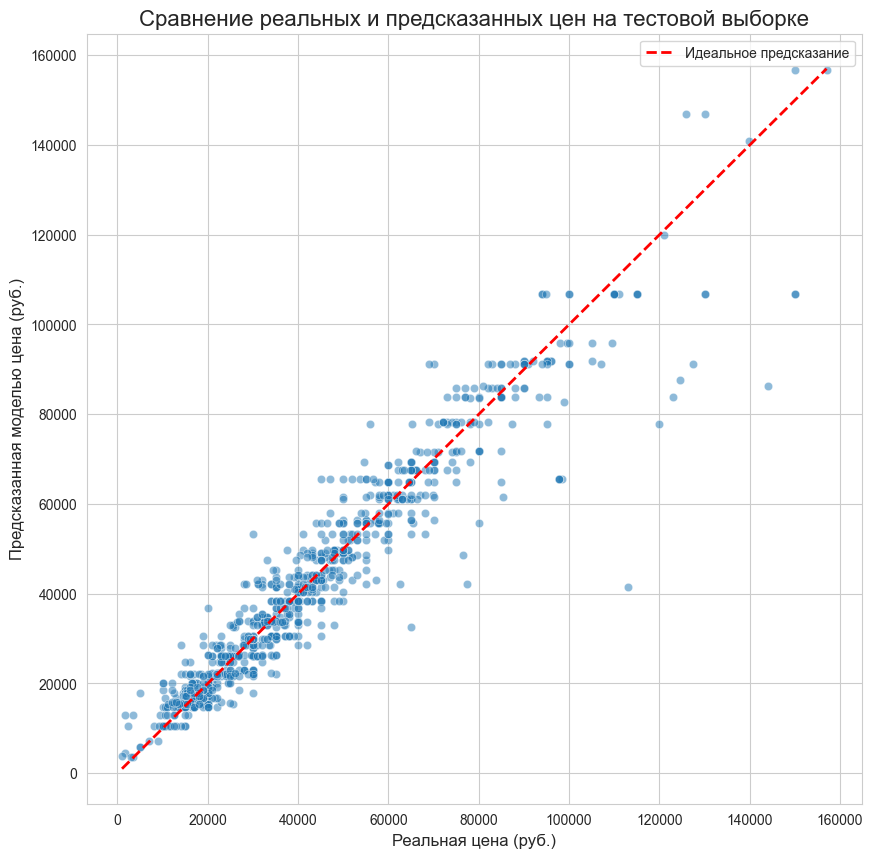

In [6]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)

min_price = min(y_test.min(), y_pred.min())
max_price = max(y_test.max(), y_pred.max())
plt.plot([min_price, max_price], [min_price, max_price], 'r--', lw=2, label='Идеальное предсказание')

plt.title('Сравнение реальных и предсказанных цен на тестовой выборке', fontsize=16)
plt.xlabel('Реальная цена (руб.)', fontsize=12)
plt.ylabel('Предсказанная моделью цена (руб.)', fontsize=12)
plt.legend()
plt.show()

In [7]:
MODEL_FILENAME = '../models/price_predictor_model.pkl'
joblib.dump(rf_model, MODEL_FILENAME)
print(f"✅ Модель успешно сохранена в: {MODEL_FILENAME}")

COLUMNS_FILENAME = '../models/model_columns.json'
model_columns = list(X_train.columns)
with open(COLUMNS_FILENAME, 'w') as f:
    json.dump(model_columns, f)
print(f"✅ Колонки 'Наивной' модели ({len(model_columns)} шт.) успешно сохранены в: {COLUMNS_FILENAME}")

print("\n🎉 Переобучение и сохранение завершены! Артефакты готовы для развертывания.")

✅ Модель успешно сохранена в: ../models/price_predictor_model.pkl
✅ Колонки 'Наивной' модели (49 шт.) успешно сохранены в: ../models/model_columns.json

🎉 Переобучение и сохранение завершены! Артефакты готовы для развертывания.
